Цель задания:
научиться анализировать результаты теста

Описание задания:

Выберите одну из трех фичей для анализа
● Понижение коэффициента surge, чтобы увеличить price-to-order конверсию (во время surge)
Ожидаем: выше price-to-order конверсия во время surge
● Если юзер Android нажимает “отменить”, предлагать промокод в случае НЕ отмены
Ожидаем: ниже отмены на Android устройствах
● При уточнении, уверен ли юзер в отмене заказа не из центра, добавить эмодзи котика, просящего не отменять
Ожидаем: ниже отмены по заказам НЕ из центра

Отфильтруйте датасет по своей гипотезе. Используйте метрику, которая описана в блоке “Ожидаем”

Постройте периодический p-value по выбранной метрике (сплит уже произведен)
● Разбейте общее количество наблюдений на 7 участков (используйте столбец даты)
● Для каждого участка используйте встроенную функцию ТТЕСТ() в excel, чтобы сравнить тестовую и котрольную группы
● 7 полученных значений p-value визуализируйте на графике

На основе графика сделайте вывод о значимости результатов.

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import math
import matplotlib.pyplot as plt
import seaborn as sns
df = pd.read_csv('post_abtest_data.csv')
print(df.shape) #количество стр. и столб.
df.info()

(101500, 11)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101500 entries, 0 to 101499
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   user_id            101500 non-null  int64  
 1   date               101500 non-null  object 
 2   app_opened         101500 non-null  int64  
 3   group              101500 non-null  object 
 4   price_seen         101500 non-null  int64  
 5   order_made         101500 non-null  int64  
 6   surge              92358 non-null   object 
 7   os                 101500 non-null  object 
 8   user_cancelled     70157 non-null   float64
 9   city_center_order  70157 non-null   float64
 10  groups             101500 non-null  object 
dtypes: float64(2), int64(4), object(5)
memory usage: 8.5+ MB


In [2]:
df['surge'] = df['surge'].fillna('no surge')# заменяем NaN на 'no surge' в кол.surge
df.surge .value_counts() # проверяем количество уникальных знач. по кол. surge

no surge    72748
surge       28752
Name: surge, dtype: int64

In [3]:
df['user_cancelled'] = df['user_cancelled'].fillna('0')# заменяем NaN на '0' в кол.user_cancelled
df['city_center_order'] = df['city_center_order'].fillna('0')# заменяем NaN на '0' в кол.city_center_order
df = df.astype({'user_cancelled': np.int}) #меняем тип данных user_cancelled на числовой
df = df.astype({'city_center_order': np.int}) #меняем тип данных city_center_order на числовой
df.info() # очищенный датафрейм

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101500 entries, 0 to 101499
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   user_id            101500 non-null  int64 
 1   date               101500 non-null  object
 2   app_opened         101500 non-null  int64 
 3   group              101500 non-null  object
 4   price_seen         101500 non-null  int64 
 5   order_made         101500 non-null  int64 
 6   surge              101500 non-null  object
 7   os                 101500 non-null  object
 8   user_cancelled     101500 non-null  int32 
 9   city_center_order  101500 non-null  int32 
 10  groups             101500 non-null  object
dtypes: int32(2), int64(4), object(5)
memory usage: 7.7+ MB


<ipython-input-3-4a77df50d6ff>:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  df = df.astype({'user_cancelled': np.int}) #меняем тип данных user_cancelled на числовой
<ipython-input-3-4a77df50d6ff>:4: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for add

In [4]:
df.head(10).T # очищенный датафрейм

,0,1,2,3,4,5,6,7,8,9
user_id,867689,867689,867689,752172,752172,486559,486559,486559,486559,486559
date,2020-05-28,2020-05-29,2020-05-25,2020-05-29,2020-05-28,2020-05-25,2020-05-31,2020-05-30,2020-05-28,2020-05-29
app_opened,1,1,1,1,1,1,1,1,1,1
group,Control,Control,Control,Control,Control,Control,Control,Control,Control,Control
price_seen,1,1,1,1,1,1,1,1,1,1
order_made,1,0,1,1,1,0,1,1,0,1
surge,no surge,surge,surge,surge,no surge,surge,no surge,no surge,surge,no surge
os,Android,iOS,Android,Android,iOS,Android,iOS,Android,iOS,Android
user_cancelled,0,0,0,0,0,0,0,0,0,0
city_center_order,1,0,0,1,0,0,0,0,0,0


In [5]:
#Гипотеза: Если юзер Android нажимает “отменить”, предлагать промокод в случае НЕ отмены
#Ожидаем: уменьшение отмен на Android устройствах
#отфильтруем df по os=='Android' (сформируем ГС из пользователей с ОС Android )
#получим количество уникальных значений по колонке os
df0 = df[df.os=='Android'] 
df0.os.value_counts()

Android    60825
Name: os, dtype: int64

In [6]:
df0.groups.value_counts()

Control    30453
Test       30372
Name: groups, dtype: int64

In [7]:
#отфильтруем df0 по groups==Control,выборка А
dfA = df0[df0.groups=='Control']
#отфильтруем df0 по groups==Test,выборка B
dfB = df0[df0.groups=='Test'] 
# выбираем нужное количество строк, чтоб выборки А(знач."Control") и В(знач."Test") были одинаковыми
dfB = dfB.iloc[0:30372] 
dfA = dfA.iloc[0:30372]
print(dfA.groups.value_counts())
print(dfB.groups.value_counts())

Control    30372
Name: groups, dtype: int64
Test    30372
Name: groups, dtype: int64


In [8]:
#Разбиваем тестовую выборку на 7 равных частей
dfB1 = dfB.iloc[0:4338]
dfB2 = dfB.iloc[4339:8677]
dfB3 = dfB.iloc[8678:13016]
dfB4 = dfB.iloc[13017:17355]
dfB5 = dfB.iloc[17356:21694]
dfB6 = dfB.iloc[21695:26033]
dfB7 = dfB.iloc[26034:30372]
dfA1 = dfA.iloc[0:4338]# Уравниваем контрольную выборку с тестовыми
dfA2 = dfA.iloc[4339:8677]
dfA3 = dfA.iloc[8678:13016]
dfA4 = dfA.iloc[13017:17355]
dfA5 = dfA.iloc[17356:21694]
dfA6 = dfA.iloc[21695:26033]
dfA7 = dfA.iloc[26034:30372]

In [9]:
A = dfA1[['order_made']]  # контрольная выборка А с одним столбцом order_made
B1 = dfB1[['order_made']] # выборка B1 с одним столбцом order_made
t, p_value = stats.ttest_ind(A, B1) #p_value и Критерий Стьюдента (t-test)
print(t, p_value)
print(stats.ttest_ind(A, B1, equal_var = False))

[-0.27991351] [0.77955054]
Ttest_indResult(statistic=array([-0.27991351]), pvalue=array([0.77955054]))


In [10]:
A = dfA2[['order_made']]
B2 = dfB2[['order_made']] # выборка B2 с одним столбцом order_made
t, p_value = stats.ttest_ind(A, B2) #p_value иКритерий Стьюдента (t-test)
print(t, p_value)
print(stats.ttest_ind(A, B2, equal_var = False))

[-2.02156749] [0.0432517]
Ttest_indResult(statistic=array([-2.02156749]), pvalue=array([0.04325171]))


In [11]:
A = dfA3[['order_made']]
B3 = dfB3[['order_made']] # выборка B3 с одним столбцом order_made
t, p_value = stats.ttest_ind(A, B3) #p_value иКритерий Стьюдента (t-test)
print(t, p_value)
print(stats.ttest_ind(A, B3, equal_var = False))

[-3.1865528] [0.0014449]
Ttest_indResult(statistic=array([-3.1865528]), pvalue=array([0.0014449]))


In [12]:
A = dfA4[['order_made']]
B4 = dfB4[['order_made']] # выборка B4 с одним столбцом order_made
t, p_value = stats.ttest_ind(A, B4) #p_value иКритерий Стьюдента (t-test)
print(t, p_value)
print(stats.ttest_ind(A, B4, equal_var = False))

[-1.89653436] [0.05792261]
Ttest_indResult(statistic=array([-1.89653436]), pvalue=array([0.05792262]))


In [13]:
A = dfA5[['order_made']]
B5 = dfB5[['order_made']] # выборка B5 с одним столбцом order_made
t, p_value = stats.ttest_ind(A, B5) #p_value иКритерий Стьюдента (t-test)
print(t, p_value)
print(stats.ttest_ind(A, B5, equal_var = False))

[-1.69130389] [0.0908147]
Ttest_indResult(statistic=array([-1.69130389]), pvalue=array([0.09081471]))


In [14]:
A = dfA6[['order_made']]
B6 = dfB6[['order_made']] # выборка B6 с одним столбцом order_made
t, p_value = stats.ttest_ind(A, B6) #p_value иКритерий Стьюдента (t-test)
print(t, p_value)
print(stats.ttest_ind(A, B6, equal_var = False))

[-1.06132542] [0.28857159]
Ttest_indResult(statistic=array([-1.06132542]), pvalue=array([0.28857159]))


In [15]:
A = dfA7[['order_made']]
B7 = dfB7[['order_made']] # выборка B7 с одним столбцом order_made
t, p_value = stats.ttest_ind(A, B7) #p_value иКритерий Стьюдента (t-test)
print(t, p_value)
print(stats.ttest_ind(A, B7, equal_var = False))

[-2.73411863] [0.00626744]
Ttest_indResult(statistic=array([-2.73411863]), pvalue=array([0.00626745]))


Text(0.5, 1.0, 'Периодический p-value')

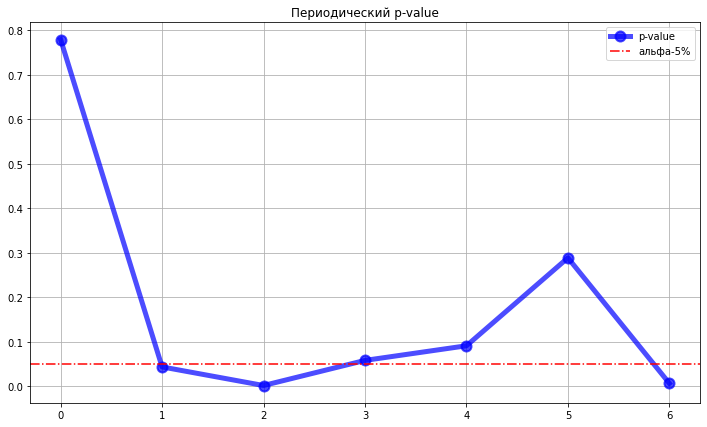

In [16]:
x = [0.77955054,0.04325171,0.0014449,0.05792262, 0.09081471,0.28857159,0.00626745]
plt.figure(figsize=(12, 7))

plt.plot(x, 'o-b',label="p-value", lw=5,alpha=0.7, mec='b', mew=2,ms=10)
plt.axhline(y=0.05, color='r', linestyle='-.',label="альфа-5%")
plt.legend()
plt.grid(True)
plt.title("Периодический p-value")

Периодический p-value не дает однозначного ответа стоит ли отвергать H0 и принимать H1.
Со второго временного промежутка альтенативная гипотеза(H1) имеет стат.значимое подтверждение:
предлагаемый владельцам Android промокод снижает отмены поездок. Имеется промежуток (c 3 по 5),
когда H1 перестает иметь стат.значимое подтверждение, что требует отдельного изучения.